In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import os

import scipy
import networkx as nx

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from numpy import linalg as LA

In [2]:
seed = 42
no_users = 10
lambda_logistic = 1e-3

In [3]:
def random_split(X, y, n, seed):
    """Equally split data between n agents"""
    rng = np.random.default_rng(seed)
    perm = rng.permutation(y.size)
    X_split = np.array_split(X[perm], n)  #np.stack to keep as a np array
    y_split = np.array_split(y[perm], n)
    return X_split, y_split

In [4]:
def loss(w, A, b, l2):
    z = b * np.dot(A, w)
    tmp = np.minimum(z, 0)
    loss = np.log((np.exp(tmp) + np.exp(tmp - z)) / np.exp(tmp))
    loss_sum = np.sum(loss) / len(b)
    reg = (np.linalg.norm(w) ** 2) * l2 / 2
    return loss_sum + reg

In [5]:
def gradient(w, A, b, l2):
    m = A.shape[0]
    bAw = b * (A @ w)
    temp = 1. / (1. + np.exp(bAw))
    res = -(A.T @ (b * temp))/m + l2 * w
    return res

In [6]:
def hessian(w, A, b, l2):
    bAw = b * (A @ w)
    activation = scipy.special.expit(bAw)
    weights = activation * (1-activation)
    A_weighted = np.multiply(A.T, weights)
    return A_weighted@A/A.shape[0] + l2*np.eye(A.shape[1])

In [7]:
def degrees(A):
    """Return the degrees of each node of a graph from its adjacency matrix"""
    return np.sum(A, axis=0).reshape(A.shape[0], 1)

In [8]:
def generate_graph(n, seed):
    """Generate a random connected graph"""
    while True:
        g = nx.generators.random_graphs.binomial_graph(n, 0.4, seed = seed) 
        if nx.algorithms.components.is_connected(g):
            return g

In [9]:
G = generate_graph(no_users, seed)
adjacency_matrix = nx.linalg.graphmatrix.adjacency_matrix(G)
print(G.number_of_edges())
print(G.number_of_nodes())
#nx.draw(G, with_labels=True, font_weight='bold')

20
10


In [10]:
theta_opt = np.load('x_opt.npy')

In [11]:
X = np.load('X.npy')
y = np.load('y.npy').ravel()

num_feature = X.shape[1] #+ 1 #+1 for bias

In [12]:
num_feature

3

In [13]:
X, y = random_split(X, y, no_users, seed)

theta = [np.zeros(num_feature) for _ in range(no_users)] # initial model

d_new = [np.zeros(num_feature) for _ in range(no_users)] # direction
d_old = [np.zeros(num_feature) for _ in range(no_users)] # old direction

lamd = [np.zeros(num_feature) for _ in range(no_users)] # dual variables

grad = [np.zeros(num_feature) for _ in range(no_users)] # old grads
Hess = [np.zeros([num_feature, num_feature]) for _ in range(no_users)] # old hessians

In [14]:
# Optimal objective function, i.e., f(x*)
obj0 = 0.02540046699809508 # a9a dataset

In [15]:
n_iters = 200
#rho =[0.05*np.log(1+t) for t in range(n_iters)]
rho =[0.5 for t in range(n_iters)]
alpha = 0.5
# Best: rho=0.004, alpha = 0.035

In [16]:
losses_dnl = []
re_dnl = np.zeros(shape=[n_iters])
op_gap_dnl = np.zeros(shape=[n_iters])
theta0 = np.zeros(num_feature)

for k in range(n_iters):
    for i in range(no_users):        
        grad[i] = gradient(theta[i], X[i], y[i], lambda_logistic)
        Hess[i] = hessian(theta[i], X[i], y[i], lambda_logistic)
    
    for i in range(no_users):
        w_neighbors_sum = np.zeros(num_feature)
        for j in G.neighbors(i):
            w_neighbors_sum = np.add(w_neighbors_sum, d_old[j])
        degree = G.degree(i)
        d_new[i] = np.matmul(np.linalg.inv(Hess[i] +  (2 * degree * rho[k] + alpha) * np.eye(num_feature)),\
                                        grad[i] - lamd[i] + rho[k] * (degree * d_old[i] + w_neighbors_sum))
            

    #print(np.linalg.norm(d_new[10]))
    
    # Dual Variable Update
    for i in range(no_users):
        w_neighbors_sum = np.zeros(num_feature)
        for j in G.neighbors(i):
            w_neighbors_sum = np.add(w_neighbors_sum, d_new[j])
        degree = G.degree(i)
        lamd[i] = lamd[i] + 1.0 * (degree * d_new[i] - w_neighbors_sum)

    #print(np.linalg.norm(lamd[10]))
        
    for i in range(no_users):
        theta[i] = theta[i] - d_new[i]
        d_old[i] = d_new[i]
        
    # Performance Check
    theta_avg = 1/no_users*sum(theta)
        
    for i in range(no_users):
        loss_dnl = np.mean([loss(theta_avg, X[i], y[i], lambda_logistic) for i in range(no_users)])
        losses_dnl.append(loss_dnl)
    
    op_gap_dnl[k] = np.abs(losses_dnl[-1] - obj0)
    
    re_dnl[k] = np.linalg.norm(theta_avg-theta_opt)/np.linalg.norm(theta0-theta_opt)
    
    print(op_gap_dnl[k], re_dnl[k])

0.5606535446192021 0.9679405086810412
0.427446612063324 0.919161754415479
0.30748051809763377 0.860396498568803
0.2154913326212941 0.7971719281968311
0.15005822231094096 0.733459524902732
0.10475361231389572 0.6715522730794906
0.07362589442088564 0.6128093986504822
0.05222431287576104 0.558055094000416
0.037416970004344366 0.5076939038331587
0.027073203894510182 0.4618396987425126
0.019769754841372163 0.4204410853985245
0.01455864928829768 0.38335633358702437
0.010804411932748694 0.3503910200380725
0.008076478363840626 0.32131704202626227
0.006079582740157543 0.2958836803651172
0.004608827705492358 0.2738260095607307
0.003520390613372313 0.2548711763763785
0.0027121585404662855 0.23874196131038605
0.00211080122477203 0.22515861972427803
0.0016630887776852774 0.21384097112366335
0.0013300174632715801 0.20451208149048752
0.001082785826083097 0.19690350268708165
0.0008999905749461842 0.19076100750816832
0.0007656383116426344 0.18584961151072596
0.0006677180728156644 0.18195714651042277
0.

# Optimality Gap

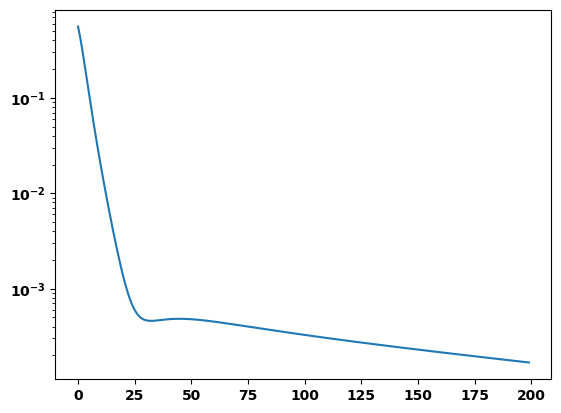

In [17]:
import matplotlib.pyplot as plt
plt.semilogy(op_gap_dnl)
#plt.ylim([10**(-5),0.5])
np.save('op_gap_dnl', op_gap_dnl)

In [18]:
theta_opt[10]

IndexError: index 10 is out of bounds for axis 0 with size 3

In [ ]:
theta_avg[10]